## Reading in a short story as text sample into Python.

In [1]:
import os

In [2]:
current_directory = os.getcwd()
os.chdir('..')

In [3]:
current_directory = os.getcwd()
print("Current Directory:", current_directory)

Current Directory: c:\Users\user\Documents\Study\llm_from_scratch


In [4]:
DATA_PATH = "data/for_tokenization/verdict.txt"

In [5]:
with open(DATA_PATH, "r", encoding="utf-8") as f:
    raw_text = f.read()
    
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


## IMPLEMENTING A SIMPLIFIED ATTENTION MECHANISM

<div class="alert alert-block alert-success">

Consider the following input sentence, which has already been embedded into 3-
dimensional vectors. 

We choose a small embedding dimension for
illustration purposes to ensure it fits on the page without line breaks:

</div>

In [7]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

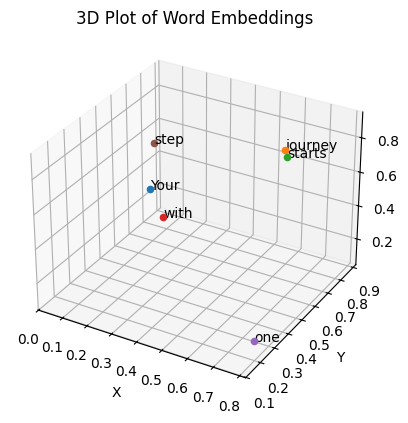

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Corresponding words
words = ['Your', 'journey', 'starts', 'with', 'one', 'step']

# Extract x, y, z coordinates
x_coords = inputs[:, 0].numpy()
y_coords = inputs[:, 1].numpy()
z_coords = inputs[:, 2].numpy()

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each point and annotate with corresponding word
for x, y, z, word in zip(x_coords, y_coords, z_coords, words):
    ax.scatter(x, y, z)
    ax.text(x, y, z, word, fontsize=10)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Plot of Word Embeddings')
plt.show()

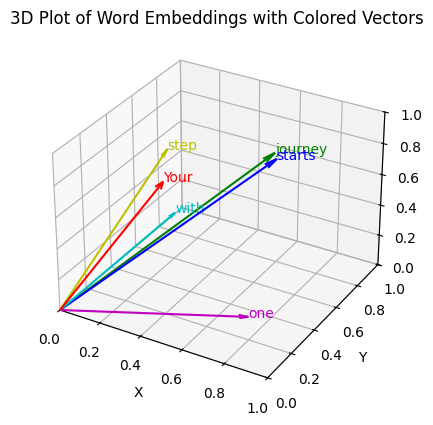

In [9]:
# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embeddings with Colored Vectors')
plt.show()


<div class="alert alert-block alert-info">
    
Each row represents a word, and each column represents an embedding dimension
    
</div>

<div class="alert alert-block alert-info">
    
The second input token serves as the query    
</div>

In [10]:
query = inputs[1]  # 2nd input token is the query

attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query) # dot product (transpose not necessary here since they are 1-dim vectors)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


<div class="alert alert-block alert-success">

In the next step, we normalize each of the attention scores that
we computed previously.

</div>

<div class="alert alert-block alert-success">

The main goal behind the normalization  is to obtain attention weights
that sum up to 1. 

This normalization is a convention that is useful for interpretation and for
maintaining training stability in an LLM. 

Here's a straightforward method for achieving this
normalization step:

</div>

In [11]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


<div class="alert alert-block alert-info">
    
In practice, it's more common and advisable to use the softmax function for normalization.

This approach is better at managing extreme values and offers more favorable gradient
properties during training. 

Below is a basic implementation of the softmax function for
normalizing the attention scores: 
</div>

In [62]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


<div class="alert alert-block alert-info">
    
As the output shows, the softmax function also meets the objective and normalizes the
attention weights such that they sum to 1:
</div>

<div class="alert alert-block alert-warning">

In addition, the softmax function ensures that the attention weights are always positive.
This makes the output interpretable as probabilities or relative importance, where higher
weights indicate greater importance.
    
</div>

<div class="alert alert-block alert-warning">

Note that this naive softmax implementation (softmax_naive) may encounter numerical
instability problems, such as overflow and underflow, when dealing with large or small input
values. 

Therefore, in practice, it's advisable to use the PyTorch implementation of softmax,
which has been extensively optimized for performance:
    
</div>

In [63]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


<div class="alert alert-block alert-info">
    
In this case, we can see that it yields the same results as our previous softmax_naive
function:
</div>

<div class="alert alert-block alert-success">

The context vector z(2)is calculated as a weighted sum of all input
vectors. 

This involves multiplying each input vector by its corresponding attention weight:

</div>

In [64]:
query = inputs[1] # 2nd input token is the query

context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


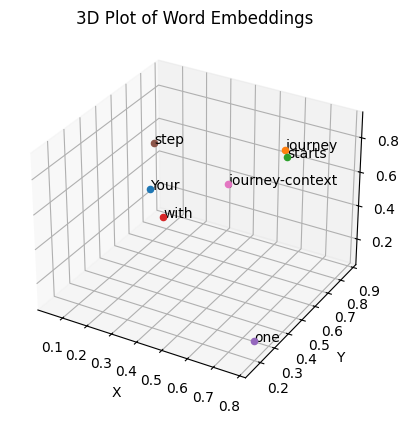

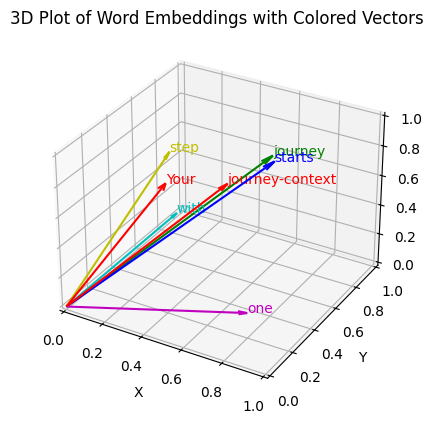

In [120]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55], # step     (x^6)
   [0.4419, 0.6515, 0.5683]]
)

# Corresponding words
words = ['Your', 'journey', 'starts', 'with', 'one', 'step', 'journey-context']

# Extract x, y, z coordinates
x_coords = inputs[:, 0].numpy()
y_coords = inputs[:, 1].numpy()
z_coords = inputs[:, 2].numpy()

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each point and annotate with corresponding word
for x, y, z, word in zip(x_coords, y_coords, z_coords, words):
    ax.scatter(x, y, z)
    ax.text(x, y, z, word, fontsize=10)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Plot of Word Embeddings')
plt.show()

# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'r']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embeddings with Colored Vectors')
plt.show()

<div class="alert alert-block alert-success">

Now, we can extend this computation to
calculate attention weights and context vectors for all inputs.

</div>

<div class="alert alert-block alert-success">

First, we add an additional for-loop to compute the
dot products for all pairs of inputs.

</div>

In [65]:
attn_scores = torch.empty(6, 6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


<div class="alert alert-block alert-info">
    
Each element in the preceding tensor represents an attention score between each pair of
inputs.
</div>

<div class="alert alert-block alert-info">
    
When computing the preceding attention score tensor, we used for-loops in Python.
                                                            
However, for-loops are generally slow, and we can achieve the same results using matrix
multiplication:
</div>

In [67]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


<div class="alert alert-block alert-success">

We now normalize each row so that the values in
each row sum to 1:

</div>

In [68]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


<div class="alert alert-block alert-warning">

In the context of using PyTorch, the dim parameter in functions like torch.softmax specifies
the dimension of the input tensor along which the function will be computed. 

By setting
dim=-1, we are instructing the softmax function to apply the normalization along the last
dimension of the attn_scores tensor. 

If attn_scores is a 2D tensor (for example, with a
shape of [rows, columns]), dim=-1 will normalize across the columns so that the values in
each row (summing over the column dimension) sum up to 1.
    
</div>

<div class="alert alert-block alert-success">

Let's briefly verify that
the rows indeed all sum to 1:

</div>

In [69]:
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)
print("All row sums:", attn_weights.sum(dim=-1))

Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


<div class="alert alert-block alert-success">

In the third and last step, we now use these attention weights to compute all context
vectors via matrix multiplication:

</div>

In [70]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


<div class="alert alert-block alert-success">

We can double-check that the code is correct by comparing the 2nd row with the context
vector z(2) calculated previously

</div>

In [71]:
print("Previous 2nd context vector:", context_vec_2)

Previous 2nd context vector: tensor([0.4419, 0.6515, 0.5683])


<div class="alert alert-block alert-info">
    
Based on the result, we can see that the previously calculated context_vec_2 matches the
second row in the previous tensor exactly
</div>

<div class="alert alert-block alert-warning">

This concludes the code walkthrough of a simple self-attention mechanism.
    
</div>

## IMPLEMENTING SELF ATTENTION WITH TRAINABLE WEIGHTS

<div class="alert alert-block alert-success">

Let's begin by defining a few variables:

</div>

<div class="alert alert-block alert-info">
    
#A The second input element

#B The input embedding size, d=3


#C The output embedding size, d_out=2

</div>

In [72]:
x_2 = inputs[1] #A
d_in = inputs.shape[1] #B
d_out = 2 #C

<div class="alert alert-block alert-info">
    
Note that in GPT-like models, the input and output dimensions are usually the same. 

But for illustration purposes, to better follow the computation, we choose different input (d_in=3)
and output (d_out=2) dimensions here.

</div>

<div class="alert alert-block alert-success">

Next, we initialize the three weight matrices Wq, Wk and Wv

</div>

In [73]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

<div class="alert alert-block alert-info">
    
Note that we are setting requires_grad=False to reduce clutter in the outputs for
illustration purposes. 

If we were to use the weight matrices for model training, we
would set requires_grad=True to update these matrices during model training.

</div>

<div class="alert alert-block alert-success">

Next, we compute the query, key, and value vectors as shown earlier
</div>

In [74]:
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print(query_2)

tensor([0.4306, 1.4551])


<div class="alert alert-block alert-info">
    
As we can see based on the output for the query, this results in a 2-dimensional vector. 

This is because: we set the number of columns of the corresponding weight matrix, via d_out, to 2:

</div>

<div class="alert alert-block alert-success">

Even though our temporary goal is to only compute the one context vector z(2),  we still
require the key and value vectors for all input elements. 

This is because they are involved in computing the attention weights with respect to the query q(2)
</div>

<div class="alert alert-block alert-success">

We can obtain all keys and values via matrix multiplication:
</div>

In [76]:
keys = inputs @ W_key
values = inputs @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


<div class="alert alert-block alert-info">
    
As we can tell from the outputs, we successfully projected the 6 input tokens from a 3D
onto a 2D embedding space:

</div>

<div class="alert alert-block alert-success">

First, let's compute the attention score ω22</div>

In [77]:
keys_2 = keys[1] #A
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


<div class="alert alert-block alert-success">
Again, we can generalize this computation to all attention scores via matrix multiplication:</div>

In [78]:
attn_scores_2 = query_2 @ keys.T # All attention scores for given query
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


<div class="alert alert-block alert-success">
    
We compute the attention weights by scaling the
attention scores and using the softmax function we used earlier. 

The difference to earlier is
that we now scale the attention scores by dividing them by the square root of the
embedding dimension of the keys. 

Note that taking the square root is mathematically the
same as exponentiating by 0.5:</div>

In [79]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


<div class="alert alert-block alert-success">
    
We now compute the context vector as a weighted sum over the value
vectors. 

Here, the attention weights serve as a weighting factor that weighs the respective
importance of each value vector. 

We can use matrix multiplication to
obtain the output in one step:</div>

In [80]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


<div class="alert alert-block alert-success">
    
So far, we only computed a single context vector, z(2). 

In the next section, we will generalize the code to compute all context vectors in the input sequence, z(1)to z (T)</div>

## IMPLEMENTING A COMPACT SELF ATTENTION PYTHON CLASS

<div class="alert alert-block alert-success">
    
In the previous sections, we have gone through a lot of steps to compute the self-attention
outputs. 

This was mainly done for illustration purposes so we could go through one step at
a time. 

In practice, with the LLM implementation in the next chapter in mind, it is helpful to
organize this code into a Python class as follows:
    
</div>

In [81]:
import torch.nn as nn

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        
        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )

        context_vec = attn_weights @ values
        return context_vec

<div class="alert alert-block alert-warning">

In this PyTorch code, SelfAttention_v1 is a class derived from nn.Module, which is a
fundamental building block of PyTorch models, which provides necessary functionalities for
model layer creation and management.    
</div>

<div class="alert alert-block alert-warning">

The __init__ method initializes trainable weight matrices (W_query, W_key, and
W_value) for queries, keys, and values, each transforming the input dimension d_in to an
output dimension d_out.

</div>

<div class="alert alert-block alert-warning">

During the forward pass, using the forward method, we compute the attention scores
(attn_scores) by multiplying queries and keys, normalizing these scores using softmax.

</div>

<div class="alert alert-block alert-success">
    
Finally, we create a context vector by weighting the values with these normalized attention
scores.
    
</div>

In [83]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


<div class="alert alert-block alert-info">

Since inputs contains six embedding vectors, we get a matrix storing the six
context vectors, as shown in the above result. 
</div>

<div class="alert alert-block alert-info">

As a quick check, notice how the second row ([0.3061, 0.8210]) matches the contents of
context_vec_2 in the previous section.
    
</div>

<div class="alert alert-block alert-warning">

We can improve the SelfAttention_v1 implementation further by utilizing PyTorch's
nn.Linear layers, which effectively perform matrix multiplication when the bias units are
disabled. 

</div>

<div class="alert alert-block alert-warning">

Additionally, a significant advantage of using nn.Linear instead of manually
implementing nn.Parameter(torch.rand(...)) is that nn.Linear has an optimized weight
initialization scheme, contributing to more stable and effective model training.

</div>

In [84]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

<div class="alert alert-block alert-success">

You can use the SelfAttention_v2 similar to SelfAttention_v1:
    
</div>

In [85]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


<div class="alert alert-block alert-info">

Note that SelfAttention_v1 and SelfAttention_v2 give different outputs because they
use different initial weights for the weight matrices since nn.Linear uses a more
sophisticated weight initialization scheme.
    
</div>

## HIDING FUTURE WORDS WITH CAUSAL ATTENTION

<div class="alert alert-block alert-success">

Let's work with the attention scores and weights from the previous section to code the causal attention mechanism.
    
</div>

<div class="alert alert-block alert-success">

In the first step illustrated in Figure 3.20, we compute the attention weights using the
softmax function as we have done in previous sections:    
</div>


<div class="alert alert-block alert-info">

Reuse the query and key weight matrices of the SelfAttention_v2 object from the previous section for
convenience
    
</div>

In [86]:
queries = sa_v2.W_query(inputs) #A
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


<div class="alert alert-block alert-success">

We can now use PyTorch's tril function to create a mask
where the values above the diagonal are zero:

</div>

In [87]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


<div class="alert alert-block alert-success">

Now, we can multiply this mask with the attention weights to zero out the values above the
diagonal:

</div>

In [89]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


<div class="alert alert-block alert-info">

As we can see, the elements above the diagonal are successfully zeroed out
    
</div>

<div class="alert alert-block alert-success">

The third step is to renormalize the attention weights to sum up to 1 again in
each row. 

We can achieve this by dividing each element in each row by the sum in each
row:

</div>

In [90]:
row_sums = masked_simple.sum(dim=1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


<div class="alert alert-block alert-info">

The result is an attention weight matrix where the attention weights above the diagonal are
zeroed out and where the rows sum to 1.

</div>

<div class="alert alert-block alert-success">

While we could be technically done with implementing causal attention at this point, we can
take advantage of a mathematical property of the softmax function. 

We can implement the computation of the masked attention weights more efficiently in fewer steps.

</div>

<div class="alert alert-block alert-success">

The softmax function converts its inputs into a probability distribution. 

When negative
infinity values (-∞) are present in a row, the softmax function treats them as zero
probability. 

(Mathematically, this is because e
-∞ approaches 0.)


We can implement this more efficient masking "trick" by creating a mask with 1's above
the diagonal and then replacing these 1's with negative infinity (-inf) values:

</div>

In [91]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


<div class="alert alert-block alert-success">

Now, all we need to do is apply the softmax function to these masked results, and we are
done.

</div>

In [92]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


<div class="alert alert-block alert-info">

As we can see based on the output, the values in each row sum to 1, and no further
normalization is necessary.

</div>

<div class="alert alert-block alert-warning">

Masking in Transformers sets scores for future tokens to a large negative value, making their influence in the softmax calculation effectively zero. 

The softmax function then recalculates attention weights only among the unmasked tokens. 

This process ensures no information leakage from masked tokens, focusing the model solely on the intended data.

</div>

<div class="alert alert-block alert-warning">

We could now use the modified attention weights to compute the context vectors via
context_vec = attn_weights @ values.

However, in the next section,
we first cover another minor tweak to the causal attention mechanism that is useful for
reducing overfitting when training LLMs.

</div>

### MASKING ADDITIONAL ATTENTION WEIGHTS WITH DROPOUT

<div class="alert alert-block alert-success">

In the following code example, we use a dropout rate of 50%, which means masking out
half of the attention weights.

When we train the GPT model in later chapters, we will use a
lower dropout rate, such as 0.1 or 0.2.
</div>

<div class="alert alert-block alert-success">

In the following code, we apply PyTorch's dropout implementation first to a 6×6 tensor
consisting of ones for illustration purposes:
</div>

In [95]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) #A
example = torch.ones(6, 6) #B
print(dropout(example))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


<div class="alert alert-block alert-info">

When applying dropout to an attention weight matrix with a rate of 50%, half of the
elements in the matrix are randomly set to zero. 

To compensate for the reduction in active
elements, the values of the remaining elements in the matrix are scaled up by a factor of
1/0.5 =2. 

This scaling is crucial to maintain the overall balance of the attention weights,
ensuring that the average influence of the attention mechanism remains consistent during
both the training and inference phases.
</div>

<div class="alert alert-block alert-success">

Now, let's apply dropout to the attention weight matrix itself:

</div>

In [96]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)


<div class="alert alert-block alert-info">

As we can see above, the resulting attention weight matrix now has additional elements zeroed out and the
remaining ones rescaled.
    
</div>

<div class="alert alert-block alert-warning">

Having gained an understanding of causal attention and dropout masking, we will
develop a concise Python class in the following section. 

This class is designed to facilitate
the efficient application of these two techniques.

</div>

### IMPLEMENTING A COMPACT CAUSAL ATTENTION CLASS

<div class="alert alert-block alert-success">

In this section, we will now incorporate the causal attention and dropout modifications into
the SelfAttention Python class we developed in section 3.4. 

This class will then serve as a
template for developing multi-head attention in the upcoming section.

</div>

<div class="alert alert-block alert-success">

Before we begin, one more thing is to ensure that the code can handle batches
consisting of more than one input. 

This will ensure that the CausalAttention class supports the batch
outputs produced by the data loader we implemented earlier.

</div>

<div class="alert alert-block alert-success">

For simplicity, to simulate such batch inputs, we duplicate the input text example:

</div>

<div class="alert alert-block alert-info">

 2 inputs with 6 tokens each, and each token has embedding dimension 3
    
</div>

In [97]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) 

torch.Size([2, 6, 3])


<div class="alert alert-block alert-info">

This results in a 3D tensor consisting of 2 input texts with 6 tokens each, where each token
is a 3-dimensional embedding vector.
    
</div>

<div class="alert alert-block alert-success">

The following CausalAttention class is similar to the SelfAttention class we
implemented earlier, except that we now added the dropout and causal mask components
as highlighted in the following code.
    
</div>

<div class="alert alert-block alert-info">

Step 1: Compared to the previous SelfAttention_v1 class, we added a dropout layer.
    
Step 2: The register_buffer call is also a new addition (more information is provided in the following text).

Step 3:  We transpose dimensions 1 and 2, keeping the batch dimension at the first position (0).

Step 4: In PyTorch, operations with a trailing underscore are performed in-place, avoiding unnecessary memory
copies
    
</div>

In [98]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

<div class="alert alert-block alert-warning">

The use of register_buffer in
PyTorch is not strictly necessary for all use cases but offers several advantages here. 

For
instance, when we use the CausalAttention class in our LLM, buffers are automatically
moved to the appropriate device (CPU or GPU) along with our model, which will be relevant
when training the LLM in future chapters. 

This means we don't need to manually ensure
these tensors are on the same device as your model parameters, avoiding device mismatch
errors.

</div>

<div class="alert alert-block alert-success">

We can use the CausalAttention class as follows, similar to SelfAttention previously:
    
</div>

In [99]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


<div class="alert alert-block alert-info">

As we can see, the resulting context vector is a 3D tensor where each token is now represented by a 2D
embedding:
    
</div>

<div class="alert alert-block alert-warning">

In the next section, we will expand on this concept
and implement a multi-head attention module, that implements several of such causal
attention mechanisms in parallel.

</div>

## EXTENDING SINGLE HEAD ATTENTION TO MULTI-HEAD ATTENTION

<div class="alert alert-block alert-success">
In practical terms, implementing multi-head attention involves creating multiple instances
of the self-attention mechanism, each with
its own weights, and then combining their outputs
    
</div>

<div class="alert alert-block alert-success">
In code, we can achieve this by implementing a simple MultiHeadAttentionWrapper
class that stacks multiple instances of our previously implemented CausalAttention
module:
    
</div>

In [100]:
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) 
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)


<div class="alert alert-block alert-info">

For example, if we use this MultiHeadAttentionWrapper class with two attention heads (via
num_heads=2) and CausalAttention output dimension d_out=2, this results in a 4-
dimensional context vectors (d_out*num_heads=4)
    
</div>

<div class="alert alert-block alert-success">
To illustrate further with a concrete example, we can use the
MultiHeadAttentionWrapper class similar to the CausalAttention class before:
</div>

In [102]:
torch.manual_seed(123)
context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


<div class="alert alert-block alert-info">

The first dimension of the resulting context_vecs tensor is 2 since we have two input texts
(the input texts are duplicated, which is why the context vectors are exactly the same for
those). 

The second dimension refers to the 6 tokens in each input. The third dimension
refers to the 4-dimensional embedding of each token.
    
</div>

<div class="alert alert-block alert-success">
In this section, we implemented a MultiHeadAttentionWrapper that combined multiple
single-head attention modules. 

However, note that these are processed sequentially via
[head(x) for head in self.heads] in the forward method. 

We can improve this
implementation by processing the heads in parallel. 

One way to achieve this is by
computing the outputs for all attention heads simultaneously via matrix multiplication, as
we will explore in the next section.
</div>

### IMPLEMENTING MULTI-HEAD ATTENTION WITH WEIGHT SPLITS

<div class="alert alert-block alert-warning">
    
Instead of maintaining two separate classes, MultiHeadAttentionWrapper and
CausalAttention, we can combine both of these concepts into a single
MultiHeadAttention class. 

Also, in addition to just merging the
MultiHeadAttentionWrapper with the CausalAttention code, we will make some other
modifications to implement multi-head attention more efficiently.
</div>

<div class="alert alert-block alert-warning">
    
In the MultiHeadAttentionWrapper, multiple heads are implemented by creating a list
of CausalAttention objects (self.heads), each representing a separate attention head.


The CausalAttention class independently performs the attention mechanism, and the
results from each head are concatenated.

In contrast, the following MultiHeadAttention
class integrates the multi-head functionality within a single class. 


It splits the input into
multiple heads by reshaping the projected query, key, and value tensors and then combines
the results from these heads after computing attention.
</div>

<div class="alert alert-block alert-success">

Let's take a look at the MultiHeadAttention class before we discuss it further:
</div>

In [103]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

<div class="alert alert-block alert-info">

Step 1: Reduce the projection dim to match desired output dim

Step 2: Use a Linear layer to combine head outputs

Step 3: Tensor shape: (b, num_tokens, d_out)

Step 4: We implicitly split the matrix by adding a `num_heads` dimension. Then we unroll last dim: (b,
num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)

Step 5: Transpose from shape (b, num_tokens, num_heads, head_dim) to (b, num_heads, num_tokens, head_dim)

Step 6: Compute dot product for each head

Step 7: Mask truncated to the number of tokens

Step 8: Use the mask to fill attention scores

Step 9: Tensor shape: (b, num_tokens, n_heads, head_dim)

Step 10: Combine heads, where self.d_out = self.num_heads * self.head_dim

Step 11: Add an optional linear projection
</div>

<div class="alert alert-block alert-warning">

Even though the reshaping (.view) and transposing (.transpose) of tensors inside the
MultiHeadAttention class looks very complicated, mathematically, the
MultiHeadAttention class implements the same concept as the
MultiHeadAttentionWrapper earlier.

</div>

<div class="alert alert-block alert-warning">

On a big-picture level, in the previous MultiHeadAttentionWrapper, we stacked
multiple single-head attention layers that we combined into a multi-head attention layer.


The MultiHeadAttention class takes an integrated approach. 

It starts with a multi-head
layer and then internally splits this layer into individual attention heads

</div>

#### DETAILED EXPLANATION OF THE MULTI-HEAD ATTENTION CLASS

<div class="alert alert-block alert-success">

The splitting of the query, key, and value tensors, is achieved
through tensor reshaping and transposing operations using PyTorch's .view and
.transpose methods. 

The input is first transformed (via linear layers for queries, keys, and
values) and then reshaped to represent multiple heads.

</div>

<div class="alert alert-block alert-success">

The key operation is to split the d_out dimension into num_heads and head_dim, where
head_dim = d_out / num_heads. 

This splitting is then achieved using the .view method: a
tensor of dimensions (b, num_tokens, d_out) is reshaped to dimension (b, num_tokens,
num_heads, head_dim).
</div>

<div class="alert alert-block alert-success">

The tensors are then transposed to bring the num_heads dimension before the
num_tokens dimension, resulting in a shape of (b, num_heads, num_tokens, head_dim).

This transposition is crucial for correctly aligning the queries, keys, and values across the
different heads and performing batched matrix multiplications efficiently.
</div>

<div class="alert alert-block alert-success">

To illustrate this batched matrix multiplication, suppose we have the following example
tensor:

</div>

In [105]:
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573], #A
[0.8993, 0.0390, 0.9268, 0.7388],
[0.7179, 0.7058, 0.9156, 0.4340]],
[[0.0772, 0.3565, 0.1479, 0.5331],
[0.4066, 0.2318, 0.4545, 0.9737],
[0.4606, 0.5159, 0.4220, 0.5786]]]])

<div class="alert alert-block alert-info">

The shape of this tensor is (b, num_heads, num_tokens, head_dim) = (1, 2, 3, 4)
</div>

<div class="alert alert-block alert-success">

Now, we perform a batched matrix multiplication between the tensor itself and a view of
the tensor where we transposed the last two dimensions, num_tokens and head_dim:

</div>

In [107]:
print(a @ a.transpose(2, 3))

tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])


<div class="alert alert-block alert-info">

In this case, the matrix multiplication implementation in PyTorch handles the 4-dimensional
input tensor so that the matrix multiplication is carried out between the 2 last dimensions
(num_tokens, head_dim) and then repeated for the individual heads.

</div>

<div class="alert alert-block alert-success">

For instance, the above becomes a more compact way to compute the matrix
multiplication for each head separately:
</div>

In [108]:
first_head = a[0, 0, :, :]
first_res = first_head @ first_head.T
print("First head:\n", first_res)
second_head = a[0, 1, :, :]
second_res = second_head @ second_head.T
print("\nSecond head:\n", second_res)

First head:
 tensor([[1.3208, 1.1631, 1.2879],
        [1.1631, 2.2150, 1.8424],
        [1.2879, 1.8424, 2.0402]])

Second head:
 tensor([[0.4391, 0.7003, 0.5903],
        [0.7003, 1.3737, 1.0620],
        [0.5903, 1.0620, 0.9912]])


<div class="alert alert-block alert-info">

The results are exactly the same results that we obtained when using the batched matrix
multiplication print(a @ a.transpose(2, 3)) earlier:

</div>

<div class="alert alert-block alert-warning">

Continuing with MultiHeadAttention, after computing the attention weights and context
vectors, the context vectors from all heads are transposed back to the shape (b,
num_tokens, num_heads, head_dim). 

These vectors are then reshaped (flattened) into the
shape (b, num_tokens, d_out), effectively combining the outputs from all heads

</div>

<div class="alert alert-block alert-warning">

Additionally, we added a so-called output projection layer (self.out_proj) to
MultiHeadAttention after combining the heads, which is not present in the
CausalAttention class. 

This output projection layer is not strictly necessary, but it is commonly used in many LLM
architectures, which is why we added it here for completeness.

</div>

<div class="alert alert-block alert-warning">

Even though the MultiHeadAttention class looks more complicated than the
MultiHeadAttentionWrapper due to the additional reshaping and transposition of tensors,
it is more efficient. 

The reason is that we only need one matrix multiplication to compute
the keys, for instance, keys = self.W_key(x) (the same is true for the queries and
values). 
                                              

In the MultiHeadAttentionWrapper, we needed to repeat this matrix multiplication,
which is computationally one of the most expensive steps, for each attention head.

</div>

<div class="alert alert-block alert-success">

The MultiHeadAttention class can be used similar to the SelfAttention and
CausalAttention classes we implemented earlier:
</div>

In [109]:
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


<div class="alert alert-block alert-info">

As we can see based on the results, the output dimension is directly controlled by the
d_out argument:

</div>

<div class="alert alert-block alert-warning">

In this section, we implemented the MultiHeadAttention class that we will use in the
upcoming sections when implementing and training the LLM itself. 


Note that while the code is fully functional, we used relatively small embedding sizes and numbers of attention
heads to keep the outputs readable.

</div>

<div class="alert alert-block alert-warning">

For comparison, the smallest GPT-2 model (117 million parameters) has 12 attention
heads and a context vector embedding size of 768. 

The largest GPT-2 model (1.5 billion
parameters) has 25 attention heads and a context vector embedding size of 1600.

Note
that the embedding sizes of the token inputs and context embeddings are the same in GPT
models (d_in = d_out).

</div>